Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Confusion Matrix (Fake Labels):
 [[600 155]
 [185 663]]
Accuracy (Fake Labels): 0.7878976918278229
Precision (Fake Labels): 0.8105134474327629
Recall (Fake Labels): 0.7818396226415094
F1 Score (Fake Labels): 0.7959183673469389

Confusion Matrix (Hate Labels):
 [[346 237]
 [126 894]]
Accuracy (Hate Labels): 0.7735495945102931
Precision (Hate Labels): 0.7904509283819628
Recall (Hate Labels): 0.8764705882352941
F1 Score (Hate Labels): 0.8312412831241284

Classification Report (Fake Labels):
               precision    recall  f1-score   support

    Not Fake       0.76      0.79      0.78       755
        Fake       0.81      0.78      0.80       848

    accuracy                           0.79      1603
   macro avg       0.79      0.79      0.79      1603
weighted avg       0.79      0.79      0.79      1603


Classification Report (Hate Labels):
            

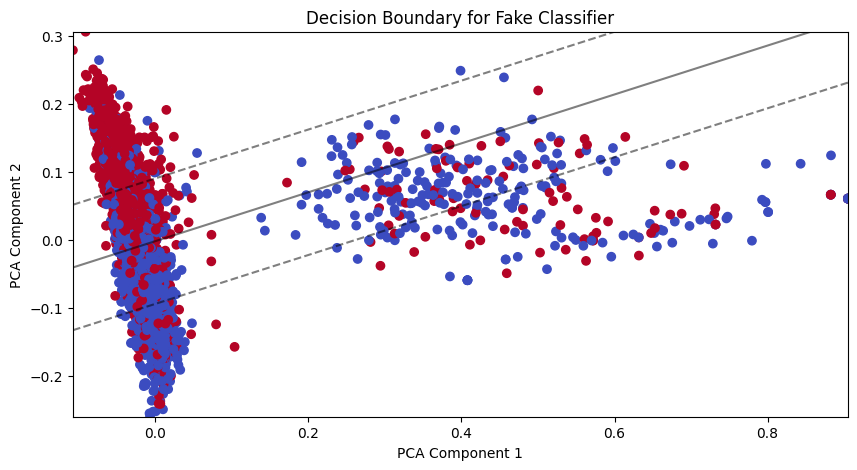

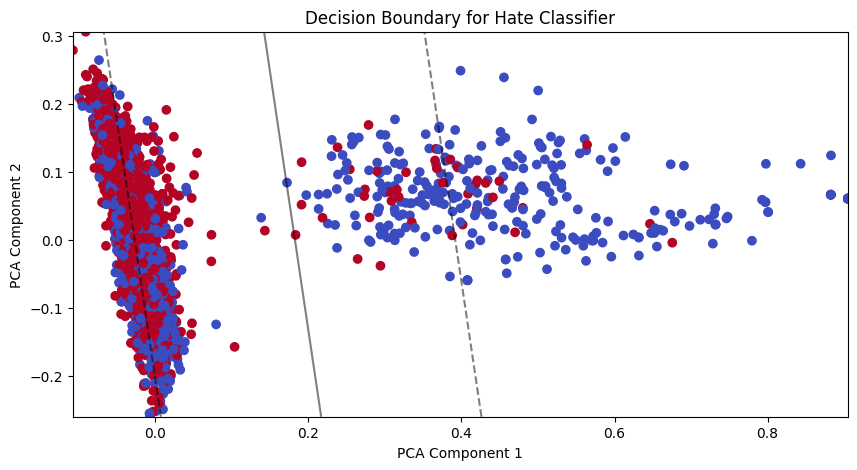

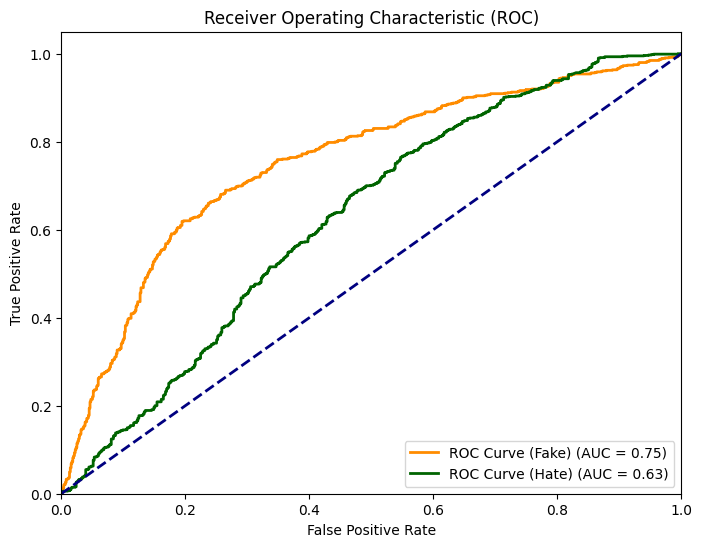

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

# Mount Google Drive to access and save files
from google.colab import drive
drive.mount('/content/drive')

# Define the folder path in Google Drive where you want to save the pickle files
folder_path = '/content/drive/My Drive/colab_results'

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Load and preprocess the dataset
try:
    # Try different encodings
    df = pd.read_csv('TWITTER+youtube.csv', encoding='latin1')
except UnicodeDecodeError:
    try:
        df = pd.read_csv('TWITTER+youtube.csv', encoding='cp1252')
    except UnicodeDecodeError:
        print("Unable to read the file using any encoding.")

selected_columns = ["Tweet", "Fake", "Hate"]
df = df[selected_columns]

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_texts = train_df["Tweet"].tolist()
train_fake_labels = train_df["Fake"].tolist()
train_hate_labels = train_df["Hate"].tolist()

val_texts = val_df["Tweet"].tolist()
val_fake_labels = val_df["Fake"].tolist()
val_hate_labels = val_df["Hate"].tolist()

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
train_tfidf = vectorizer.fit_transform(train_texts).toarray()
val_tfidf = vectorizer.transform(val_texts).toarray()

# Define SVM classifiers
svm_classifier_fake = SVC(kernel='linear', C=1.0)
svm_classifier_hate = SVC(kernel='linear', C=1.0)

# Train SVM classifier for "fake" labels
svm_classifier_fake.fit(train_tfidf, train_fake_labels)

# Predict on validation data for "fake" labels
val_fake_preds = svm_classifier_fake.predict(val_tfidf)

# Calculate metrics for "fake" labels
fake_conf_matrix = confusion_matrix(val_fake_labels, val_fake_preds)
fake_accuracy = accuracy_score(val_fake_labels, val_fake_preds)
fake_precision, fake_recall, fake_f1, _ = precision_recall_fscore_support(val_fake_labels, val_fake_preds, average='binary')

print("Confusion Matrix (Fake Labels):\n", fake_conf_matrix)
print("Accuracy (Fake Labels):", fake_accuracy)
print("Precision (Fake Labels):", fake_precision)
print("Recall (Fake Labels):", fake_recall)
print("F1 Score (Fake Labels):", fake_f1)

# Train SVM classifier for "hate" labels
svm_classifier_hate.fit(train_tfidf, train_hate_labels)

# Predict on validation data for "hate" labels
val_hate_preds = svm_classifier_hate.predict(val_tfidf)

# Calculate metrics for "hate" labels
hate_conf_matrix = confusion_matrix(val_hate_labels, val_hate_preds)
hate_accuracy = accuracy_score(val_hate_labels, val_hate_preds)
hate_precision, hate_recall, hate_f1, _ = precision_recall_fscore_support(val_hate_labels, val_hate_preds, average='binary')

print("\nConfusion Matrix (Hate Labels):\n", hate_conf_matrix)
print("Accuracy (Hate Labels):", hate_accuracy)
print("Precision (Hate Labels):", hate_precision)
print("Recall (Hate Labels):", hate_recall)
print("F1 Score (Hate Labels):", hate_f1)

# Calculate and print classification report for "fake" labels
fake_classification_report = classification_report(val_fake_labels, val_fake_preds, target_names=["Not Fake", "Fake"])
print("\nClassification Report (Fake Labels):\n", fake_classification_report)

# Calculate and print classification report for "hate" labels
hate_classification_report = classification_report(val_hate_labels, val_hate_preds, target_names=["Not Hate", "Hate"])
print("\nClassification Report (Hate Labels):\n", hate_classification_report)

# Reduce dimensionality of TF-IDF vectors using PCA (you can adjust n_components)
pca = PCA(n_components=2)
train_tfidf_reduced = pca.fit_transform(train_tfidf)
val_tfidf_reduced = pca.transform(val_tfidf)

# Train SVM classifier for "fake" labels with reduced features
svm_classifier_fake.fit(train_tfidf_reduced, train_fake_labels)

# Create grid to evaluate model for "fake" classifier
xx_fake, yy_fake = np.meshgrid(np.linspace(train_tfidf_reduced[:, 0].min(), train_tfidf_reduced[:, 0].max(), 100),
                     np.linspace(train_tfidf_reduced[:, 1].min(), train_tfidf_reduced[:, 1].max(), 100))
Z_fake = svm_classifier_fake.decision_function(np.c_[xx_fake.ravel(), yy_fake.ravel()])
Z_fake = Z_fake.reshape(xx_fake.shape)

# Visualize decision boundary for "fake" classifier
plt.figure(figsize=(10, 5))
plt.contour(xx_fake, yy_fake, Z_fake, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.scatter(train_tfidf_reduced[:, 0], train_tfidf_reduced[:, 1], c=train_fake_labels, cmap='coolwarm', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary for Fake Classifier')
plt.show()

# Train SVM classifier for "hate" labels with reduced features
svm_classifier_hate.fit(train_tfidf_reduced, train_hate_labels)

# Create grid to evaluate model for "hate" classifier
xx_hate = np.linspace(train_tfidf_reduced[:, 0].min(), train_tfidf_reduced[:, 0].max(), 100)
yy_hate = np.linspace(train_tfidf_reduced[:, 1].min(), train_tfidf_reduced[:, 1].max(), 100)
xx_hate, yy_hate = np.meshgrid(xx_hate, yy_hate)
Z_hate = svm_classifier_hate.decision_function(np.c_[xx_hate.ravel(), yy_hate.ravel()])
Z_hate = Z_hate.reshape(xx_hate.shape)

# Visualize decision boundary for "hate" classifier
plt.figure(figsize=(10, 5))
plt.contour(xx_hate, yy_hate, Z_hate, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.scatter(train_tfidf_reduced[:, 0], train_tfidf_reduced[:, 1], c=train_hate_labels, cmap='coolwarm', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary for Hate Classifier')
plt.show()

# ROC Curve for "fake" classifier
fake_probs = svm_classifier_fake.decision_function(val_tfidf_reduced)
fpr_fake, tpr_fake, _ = roc_curve(val_fake_labels, fake_probs)
roc_auc_fake = auc(fpr_fake, tpr_fake)

# ROC Curve for "hate" classifier
hate_probs = svm_classifier_hate.decision_function(val_tfidf_reduced)
fpr_hate, tpr_hate, _ = roc_curve(val_hate_labels, hate_probs)
roc_auc_hate = auc(fpr_hate, tpr_hate)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_fake, tpr_fake, color='darkorange', lw=2, label='ROC Curve (Fake) (AUC = %0.2f)' % roc_auc_fake)
plt.plot(fpr_hate, tpr_hate, color='darkgreen', lw=2, label='ROC Curve (Hate) (AUC = %0.2f)' % roc_auc_hate)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Save SVM classifiers to pickle files in Google Drive
with open(os.path.join(folder_path, 'svm_classifier_fake.pkl'), 'wb') as fake_file, open(os.path.join(folder_path, 'svm_classifier_hate.pkl'), 'wb') as hate_file:
    pickle.dump(svm_classifier_fake, fake_file)
    pickle.dump(svm_classifier_hate, hate_file)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

# Load and preprocess the dataset
try:
    # Try different encodings
    df = pd.read_csv('TWITTER+youtube.csv', encoding='latin1')
except UnicodeDecodeError:
    try:
        df = pd.read_csv('TWITTER+youtube.csv', encoding='cp1252')
    except UnicodeDecodeError:
        print("Unable to read the file using any encoding.")

selected_columns = ["Tweet", "Target", "Severity"]  # Change column names
df = df[selected_columns]

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_texts = train_df["Tweet"].tolist()
train_target_labels = train_df["Target"].tolist()  # Change to "Target" labels
train_severity_labels = train_df["Severity"].tolist()  # Change to "Severity" labels

val_texts = val_df["Tweet"].tolist()
val_target_labels = val_df["Target"].tolist()  # Change to "Target" labels
val_severity_labels = val_df["Severity"].tolist()  # Change to "Severity" labels

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
train_tfidf = vectorizer.fit_transform(train_texts).toarray()
val_tfidf = vectorizer.transform(val_texts).toarray()

# Define SVM classifiers
svm_classifier_target = SVC(kernel='linear', C=1.0, decision_function_shape='ovr', probability=True)
svm_classifier_severity = SVC(kernel='linear', C=1.0, decision_function_shape='ovr', probability=True)

# Train SVM classifier for "Target" labels with multi-core parallelization
svm_classifier_target.fit(train_tfidf, train_target_labels)

# Predict on validation data for "Target" labels
val_target_preds = svm_classifier_target.predict(val_tfidf)

# Calculate metrics for "Target" labels
target_conf_matrix = confusion_matrix(val_target_labels, val_target_preds)
target_accuracy = accuracy_score(val_target_labels, val_target_preds)
target_precision, target_recall, target_f1, _ = precision_recall_fscore_support(val_target_labels, val_target_preds, average='weighted')

print("Confusion Matrix (Target Labels):\n", target_conf_matrix)
print("Accuracy (Target Labels):", target_accuracy)
print("Precision (Target Labels):", target_precision)
print("Recall (Target Labels):", target_recall)
print("F1 Score (Target Labels):", target_f1)

# Train SVM classifier for "Severity" labels with multi-core parallelization
svm_classifier_severity.fit(train_tfidf, train_severity_labels)

# Predict on validation data for "Severity" labels
val_severity_preds = svm_classifier_severity.predict(val_tfidf)

# Calculate metrics for "Severity" labels
severity_conf_matrix = confusion_matrix(val_severity_labels, val_severity_preds)
severity_accuracy = accuracy_score(val_severity_labels, val_severity_preds)
severity_precision, severity_recall, severity_f1, _ = precision_recall_fscore_support(val_severity_labels, val_severity_preds, average='weighted')

print("\nConfusion Matrix (Severity Labels):\n", severity_conf_matrix)
print("Accuracy (Severity Labels):", severity_accuracy)
print("Precision (Severity Labels):", severity_precision)
print("Recall (Severity Labels):", severity_recall)
print("F1 Score (Severity Labels):", severity_f1)

# Calculate and print classification report for "Target" labels
target_classification_report = classification_report(val_target_labels, val_target_preds, target_names=["Class 0", "Class 1", "Class 2", "Class 3"])
print("\nClassification Report (Target Labels):\n", target_classification_report)


# Calculate and print classification report for "Severity" labels
severity_classification_report = classification_report(val_severity_labels, val_severity_preds, target_names=["Class 0", "Class 1", "Class 2", "Class 3"])
print("\nClassification Report (Severity Labels):\n", severity_classification_report)

# Reduce dimensionality of TF-IDF vectors using PCA (you can adjust n_components)
pca = PCA(n_components=2)
train_tfidf_reduced = pca.fit_transform(train_tfidf)
val_tfidf_reduced = pca.transform(val_tfidf)

# Train SVM classifier for "Target" labels with reduced features


Confusion Matrix (Target Labels):
 [[451  27  74  29]
 [ 97 135  29  12]
 [110  25 431   3]
 [ 65  13  32  70]]
Accuracy (Target Labels): 0.6781035558328135
Precision (Target Labels): 0.6802917164534947
Recall (Target Labels): 0.6781035558328135
F1 Score (Target Labels): 0.6709773079912543

Confusion Matrix (Severity Labels):
 [[416  14 108  43]
 [ 30  36  43  45]
 [142  12 222 111]
 [ 56  11  88 226]]
Accuracy (Severity Labels): 0.561447286338116
Precision (Severity Labels): 0.5541937078115949
Recall (Severity Labels): 0.561447286338116
F1 Score (Severity Labels): 0.5522162619313751

Classification Report (Target Labels):
               precision    recall  f1-score   support

     Class 0       0.62      0.78      0.69       581
     Class 1       0.68      0.49      0.57       273
     Class 2       0.76      0.76      0.76       569
     Class 3       0.61      0.39      0.48       180

    accuracy                           0.68      1603
   macro avg       0.67      0.60      0.6

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier  # You can choose another classifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pickle

# Mount Google Drive to access and save files (for Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder path in Google Drive where you want to save the pickle files
folder_path = '/content/drive/My Drive/colab_results'

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Load and preprocess the dataset
try:
    # Try different encodings
    df = pd.read_csv('TWITTER+youtube.csv', encoding='latin1')
except UnicodeDecodeError:
    try:
        df = pd.read_csv('TWITTER+youtube.csv', encoding='cp1252')
    except UnicodeDecodeError:
        print("Unable to read the file using any encoding.")

selected_columns = ["Tweet", "Target", "Severity"]
df = df[selected_columns]

# Convert "Target" and "Severity" labels to numerical labels dynamically
def map_labels(label_column):
    label_mapping = {}
    labels = df[label_column].unique()
    for i, label in enumerate(labels):
        label_mapping[label] = i
    return label_mapping

target_mapping = map_labels("Target")
severity_mapping = map_labels("Severity")

df["Target"] = df["Target"].map(target_mapping)
df["Severity"] = df["Severity"].map(severity_mapping)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_texts = train_df["Tweet"].tolist()
train_target_labels = train_df["Target"].tolist()
train_severity_labels = train_df["Severity"].tolist()

val_texts = val_df["Tweet"].tolist()
val_target_labels = val_df["Target"].tolist()
val_severity_labels = val_df["Severity"].tolist()

# Replace None or NaN values with empty strings in train_texts and val_texts
train_texts = ['' if text is None or pd.isna(text) else text for text in train_texts]
val_texts = ['' if text is None or pd.isna(text) else text for text in val_texts]

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
train_tfidf = vectorizer.fit_transform(train_texts).toarray()
val_tfidf = vectorizer.transform(val_texts).toarray()


# Choose a classifier (Random Forest in this example)
classifier_target = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_severity = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier for "Target" labels
classifier_target.fit(train_tfidf, train_target_labels)

# Predict on validation data for "Target" labels
val_target_preds = classifier_target.predict(val_tfidf)

# Train the classifier for "Severity" labels
classifier_severity.fit(train_tfidf, train_severity_labels)

# Predict on validation data for "Severity" labels
val_severity_preds = classifier_severity.predict(val_tfidf)

# Evaluate the classifier for "Target" labels
target_accuracy = accuracy_score(val_target_labels, val_target_preds)
target_classification_report = classification_report(val_target_labels, val_target_preds)
target_conf_matrix = confusion_matrix(val_target_labels, val_target_preds)

# Evaluate the classifier for "Severity" labels
severity_accuracy = accuracy_score(val_severity_labels, val_severity_preds)
severity_classification_report = classification_report(val_severity_labels, val_severity_preds)
severity_conf_matrix = confusion_matrix(val_severity_labels, val_severity_preds)

print("Accuracy (Target Labels):", target_accuracy)
print("Classification Report (Target Labels):\n", target_classification_report)
print("Confusion Matrix (Target Labels):\n", target_conf_matrix)

print("Accuracy (Severity Labels):", severity_accuracy)
print("Classification Report (Severity Labels):\n", severity_classification_report)
print("Confusion Matrix (Severity Labels):\n", severity_conf_matrix)

# Save the models to pickle files in Google Drive
with open(os.path.join(folder_path, 'classifier_target.pkl'), 'wb') as target_file:
    pickle.dump(classifier_target, target_file)

with open(os.path.join(folder_path, 'classifier_severity.pkl'), 'wb') as severity_file:
    pickle.dump(classifier_severity, severity_file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Accuracy (Target Labels): 0.6573033707865169
Classification Report (Target Labels):
               precision    recall  f1-score   support

           0       0.58      0.81      0.67       568
           1       0.77      0.76      0.76       568
           2       0.67      0.36      0.47       272
           3       0.69      0.32      0.43       186
           4       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         1

    accuracy                           0.66      1602
   macro avg       0.39      0.32      0.33      1602
weighted avg       0.67      0.66      0.64      1602

Confusion Matrix (Target Labels):
 [[462  69  21  16   0   0   0]
 [113 433  19   3   0   0   0]
 [144  21  99   8   0   0   0]
 [ 77  42   8  59   0   0   0]
 [  1   1   0   0   0   0   0]
 [  4   0   1   0   0   0   0]
 [  1   0   0   0   0   0   0]]
Accuracy (Severity Labels): 0.5692883895131086
Classification Rep